Change endpoint hostname to match your Mongo instance.

In [1]:
import os
os.environ["MONGODB_ENDPOINT"] = "mongodb://localhost:27017"

In [2]:
from utils import connect_to_mongodb
from pymongo import ASCENDING, DESCENDING

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

db = connect_to_mongodb()

## Private sandwiches
Analyze the prevalence of sandwich MEVs in different contexts.

Total blocks: 774725
Blocks containing at least one frontrunning attack: 80093 out of 774725 10.338249056116688


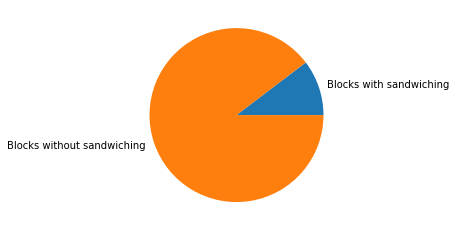

Sandwiching attacks between November 23, 2021 and March 23, 2022: 99928
Sandwiching attacks between November 23, 2021 and March 23, 2022 using flashbots: 81089
Sandwiching attacks between November 23, 2021 and March 23, 2022 without flashbots: 18839


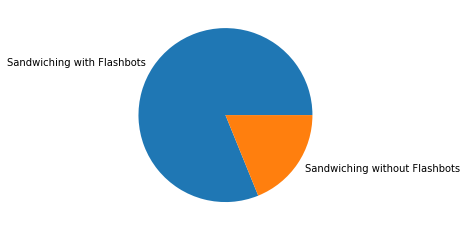

Public sandwiching attacks: 5601
Private sandwiching attacks: 13238


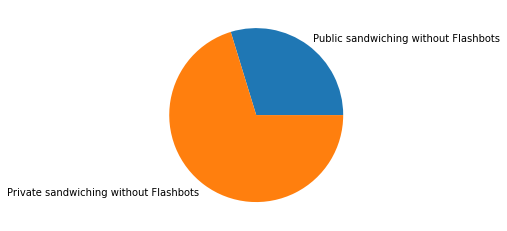

In [3]:
# Search for private sandwiching that is not related to flashbots
sandwiches = db.flashbots.sandwich_results

blocks = set()
cursor = sandwiches.find({"block_number":{"$gte":13670000,"$lte":14444725}},{"block_number":1})
for value in cursor:
    blocks.add(value["block_number"])    
results_count = len(blocks)
total = 14444725 - 13670000 # 23.11.2021 - 23.03.2022 --> 4 months
print("Total blocks:", total)
print("Blocks containing at least one frontrunning attack:", results_count, "out of", total, results_count / total * 100.0)
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.pie([results_count, total-results_count], labels = ["Blocks with sandwiching", "Blocks without sandwiching"])
plt.show()

sandwiching_attacks = list()
cursor = sandwiches.find({"block_number":{"$gte":13670000,"$lte":14444725}},{"block_number":1})
for value in cursor:
    sandwiching_attacks.append(value["block_number"])
print("Sandwiching attacks between November 23, 2021 and March 23, 2022:", len(sandwiching_attacks))

flashbots_sandwiching_attacks = list()
cursor = sandwiches.find({"block_number":{"$gte":13670000,"$lte":14444725}, "flashbots_bundle":True},{"block_number":1})
for value in cursor:
    flashbots_sandwiching_attacks.append(value["block_number"])
print("Sandwiching attacks between November 23, 2021 and March 23, 2022 using flashbots:", len(flashbots_sandwiching_attacks))

without_flashbots_sandwiching_attacks = list()
cursor = sandwiches.find({"block_number":{"$gte":13670000,"$lte":14444725}, "flashbots_bundle":False},{"block_number":1})
for value in cursor:
    without_flashbots_sandwiching_attacks.append(value["block_number"])
print("Sandwiching attacks between November 23, 2021 and March 23, 2022 without flashbots:", len(without_flashbots_sandwiching_attacks))

assert(len(sandwiching_attacks) == len(flashbots_sandwiching_attacks)+len(without_flashbots_sandwiching_attacks))
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.pie([len(flashbots_sandwiching_attacks), len(without_flashbots_sandwiching_attacks)], labels = ["Sandwiching with Flashbots", "Sandwiching without Flashbots"])
plt.show()

observed_transactions = db.flashbots.observed_transactions
cursor = sandwiches.find({"block_number":{"$gte":13670000,"$lte":14444725}, "flashbots_bundle":False})
data = list()
for document in cursor:
    first_transaction_found = observed_transactions.find_one({"hash":document["first_transaction"]["hash"]})
    whale_transaction_found = observed_transactions.find_one({"hash":document["whale_transaction"]["hash"]})
    second_transaction_found = observed_transactions.find_one({"hash":document["second_transaction"]["hash"]})
    if first_transaction_found == None and whale_transaction_found != None and second_transaction_found == None:
        data.append({
            "block_number": document["block_number"],
            "miner": document["miner"],
            "transactions": [
                {
                    "from": document["first_transaction"]["from"],
                    "to": document["first_transaction"]["to"],
                    "hash": document["first_transaction"]["hash"]
                },
                {
                    "from": document["second_transaction"]["from"],
                    "to": document["second_transaction"]["to"],
                    "hash": document["second_transaction"]["hash"]
                }
            ]
        })

public_sandwiching_attacks = len(without_flashbots_sandwiching_attacks) - len(data)
print("Public sandwiching attacks:", public_sandwiching_attacks)
private_sandwiching_attacks = len(data)
print("Private sandwiching attacks:", private_sandwiching_attacks)
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.pie([public_sandwiching_attacks, private_sandwiching_attacks], labels = ["Public sandwiching without Flashbots", "Private sandwiching without Flashbots"])
plt.show()

## MEV distribution among private/public pools

99928


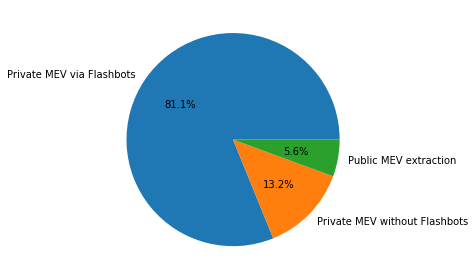

In [4]:
fig = plt.figure()
fig.patch.set_facecolor('white')
print(len(flashbots_sandwiching_attacks) + private_sandwiching_attacks + public_sandwiching_attacks)
plt.pie([len(flashbots_sandwiching_attacks), private_sandwiching_attacks, public_sandwiching_attacks], labels = ["Private MEV via Flashbots", "Private MEV without Flashbots", "Public MEV extraction"], autopct='%1.1f%%')
fig.tight_layout()
import matplotlib
matplotlib.rcParams.update({'font.size': 12})
plt.savefig("private_mev_distribution.pdf", dpi=1000, bbox_inches='tight')

## Private pool miner analysis

In [5]:
miners = dict()
bots = dict()
bots_and_miners = dict()
for entry in data:
    if not entry["miner"] in miners:
        miners[entry["miner"]] = 0
    miners[entry["miner"]] += 1
    
    if not entry["transactions"][0]["to"] in bots:
        bots[entry["transactions"][0]["to"]] = 0
    bots[entry["transactions"][0]["to"]] += 1
    
    if not entry["transactions"][0]["to"] in bots_and_miners:
        bots_and_miners[entry["transactions"][0]["to"]] = dict()
    if not entry["miner"] in bots_and_miners[entry["transactions"][0]["to"]]:
        bots_and_miners[entry["transactions"][0]["to"]][entry["miner"]] = 0
    bots_and_miners[entry["transactions"][0]["to"]][entry["miner"]] += 1
    
print("Miners that do private frontrunning attacks:")

print("Number of miners:", len(miners))
for miner in miners:
    print(miner, miners[miner])
print()
print("Number of bots:", len(bots))
for bot in bots:
    print(bot, bots[bot])
    for miner in bots_and_miners[bot]:
        print("  miner:", miner, bots_and_miners[bot][miner])

Miners that do private frontrunning attacks:
Number of miners: 35
0x829BD824B016326A401d083B33D092293333A830 5126
0xEA674fdDe714fd979de3EdF0F56AA9716B898ec8 269
0x1aD91ee08f21bE3dE0BA2ba6918E714dA6B45836 692
0x7F101fE45e6649A6fB8F3F8B43ed03D353f2B90c 815
0x0708F87A089a91C65d48721Aa941084648562287 106
0x52bc44d5378309EE2abF1539BF71dE1b7d7bE3b5 515
0x45a36a8e118C37e4c47eF4Ab827A7C9e579E11E2 569
0xEEa5B82B61424dF8020f5feDD81767f2d0D25Bfb 264
0xB7e390864a90b7b923C9f9310C6F98aafE43F707 634
0x00192Fb10dF37c9FB26829eb2CC623cd1BF599E8 500
0x4069e799Da927C06b430e247b2ee16C03e8B837d 203
0x3EcEf08D0e2DaD803847E052249bb4F8bFf2D5bB 548
0x6EBaF477F83E055589C1188bCC6DDCCD8C9B131a 199
0xc3348B43d3881151224b490e4aa39E03d2B1cDEa 319
0x2A20380DcA5bC24D052acfbf79ba23e988ad0050 353
0x8F03f1a3f10c05E7CCcF75C1Fd10168e06659Be7 304
0x2DaA35962A6D43EB54C48367b33d0B379C930E5e 243
0xCD458d7F11023556cC9058F729831a038Cb8Df9c 481
0x002e08000acbbaE2155Fab7AC01929564949070d 61
0x433022C4066558E7a32D850F02d2da5cA782174

  miner: 0x7F101fE45e6649A6fB8F3F8B43ed03D353f2B90c 47
  miner: 0x249bdb4499bd7c683664C149276C1D86108E2137 2
  miner: 0x26B3eEA1CD34a4aFF7Ce828A5F71DAAC042d38E0 1
0x46C4128981525aA446e02FFb2FF762F1D6A49170 80
  miner: 0xEA674fdDe714fd979de3EdF0F56AA9716B898ec8 3
  miner: 0x3EcEf08D0e2DaD803847E052249bb4F8bFf2D5bB 4
  miner: 0xc365c3315cF926351CcAf13fA7D19c8C4058C8E1 3
  miner: 0x6EBaF477F83E055589C1188bCC6DDCCD8C9B131a 2
  miner: 0xB7e390864a90b7b923C9f9310C6F98aafE43F707 8
  miner: 0x52bc44d5378309EE2abF1539BF71dE1b7d7bE3b5 7
  miner: 0x2A20380DcA5bC24D052acfbf79ba23e988ad0050 5
  miner: 0xc3348B43d3881151224b490e4aa39E03d2B1cDEa 2
  miner: 0x00192Fb10dF37c9FB26829eb2CC623cd1BF599E8 5
  miner: 0xBbbBbBbb49459e69878219F906e73Aa325ff2F0C 1
  miner: 0x537B6bd3caEB0d41540aC1Fd406b9ACDa5670aaD 1
  miner: 0x8F03f1a3f10c05E7CCcF75C1Fd10168e06659Be7 4
  miner: 0x0708F87A089a91C65d48721Aa941084648562287 1
  miner: 0xCD458d7F11023556cC9058F729831a038Cb8Df9c 6
  miner: 0x45a36a8e118C37e4c47eF4Ab

  miner: 0x829BD824B016326A401d083B33D092293333A830 121
0x1EbAdD3E0BB6d4e9EdB574C5f0B0edc23c815D95 1
  miner: 0x5B56F09e7D6272FC014f8526A5290700c5Bb302b 1
0x5ede0fedbfE6e1B1fE8B1F9228478bB8F23C6E0E 1
  miner: 0xB7e390864a90b7b923C9f9310C6F98aafE43F707 1
0x000000000000084e91743124a982076C59f10084 1
  miner: 0xEA674fdDe714fd979de3EdF0F56AA9716B898ec8 1
0xB3fCD22ffD34D75C979D49E2E5fb3a3405644831 50
  miner: 0x7F101fE45e6649A6fB8F3F8B43ed03D353f2B90c 5
  miner: 0xc365c3315cF926351CcAf13fA7D19c8C4058C8E1 3
  miner: 0x829BD824B016326A401d083B33D092293333A830 11
  miner: 0xc3348B43d3881151224b490e4aa39E03d2B1cDEa 7
  miner: 0x1aD91ee08f21bE3dE0BA2ba6918E714dA6B45836 3
  miner: 0x4F9bEBE3adC3c7f647C0023C60f91AC9dfFA52d5 1
  miner: 0xCD458d7F11023556cC9058F729831a038Cb8Df9c 3
  miner: 0xB7e390864a90b7b923C9f9310C6F98aafE43F707 3
  miner: 0x3EcEf08D0e2DaD803847E052249bb4F8bFf2D5bB 8
  miner: 0x5B56F09e7D6272FC014f8526A5290700c5Bb302b 1
  miner: 0x2A20380DcA5bC24D052acfbf79ba23e988ad0050 3
  mine

## Private pool bot analysis

In [6]:
print("Bots whose transactions have always been mined by the same miner")
for bot in bots:
    if len(bots_and_miners[bot]) == 1:
        for miner in bots_and_miners[bot]:
            if bots_and_miners[bot][miner] > 1:
                print(bot, bots[bot])
                print("  miner:", miner, bots_and_miners[bot][miner])
print()
print("Bots whose transactions have always been mined by more than one miner")
for bot in bots:
    if len(bots_and_miners[bot]) > 1:
        print(bot, bots[bot])
        for miner in bots_and_miners[bot]:
            print("  miner:", miner, bots_and_miners[bot][miner])

Bots whose transactions have always been mined by the same miner
0x42B2C65dB7F9e3b6c26Bc6151CCf30CcE0fb99EA 30
  miner: 0x7F101fE45e6649A6fB8F3F8B43ed03D353f2B90c 30
0xDD28D64E40e00aF54a0B5147539A515C4A0bC1c5 121
  miner: 0x829BD824B016326A401d083B33D092293333A830 121

Bots whose transactions have always been mined by more than one miner
0x7Cf09D7A9A74f746EDcb06949B9d64bCd9D1604f 2573
  miner: 0x829BD824B016326A401d083B33D092293333A830 1733
  miner: 0xEA674fdDe714fd979de3EdF0F56AA9716B898ec8 115
  miner: 0xEEa5B82B61424dF8020f5feDD81767f2d0D25Bfb 82
  miner: 0x1aD91ee08f21bE3dE0BA2ba6918E714dA6B45836 68
  miner: 0xB7e390864a90b7b923C9f9310C6F98aafE43F707 66
  miner: 0xc3348B43d3881151224b490e4aa39E03d2B1cDEa 23
  miner: 0x45a36a8e118C37e4c47eF4Ab827A7C9e579E11E2 40
  miner: 0x6EBaF477F83E055589C1188bCC6DDCCD8C9B131a 18
  miner: 0x2DaA35962A6D43EB54C48367b33d0B379C930E5e 18
  miner: 0x002e08000acbbaE2155Fab7AC01929564949070d 12
  miner: 0x00192Fb10dF37c9FB26829eb2CC623cd1BF599E8 60
  mi